In [1]:
import sys
sys.path.append("/Users/irisstone/Google Drive (istone@princeton.edu)/Princeton/Research/Striatum Towers Task/code/glmhmm")
import matplotlib.pyplot as plt
import numpy as np
import time
from glmhmm import hmm
from glmhmm.utils import permute_states, find_best_fit
from glmhmm.visualize import plot_transitions

If the data is difficult to fit, we can also try a method called direct annealing EM, or DAEM (for more information, see [Ueda and Nakano 1998](https://www.sciencedirect.com/science/article/pii/S0893608097001330)). In short, this applies a temperature parameter $B$ to our posterior, starting at a low value ($B<1$), which tends to produce faster convergence of the log-likelihood than traditional EM. The estimates of the fitted parameters then become initial parameter values (presumably closer to the correct parameter values than random initializations) for a second round of EM, with $B$ increased. This process continues iteratively, with $B$ increasing in each round of EM by a pre-specified step size, until $B=1$. With this method, we get more consistent estimates of the log-likelihood that match the global optimum and that are less sensitive to initialization.

In [2]:
# set the parameters of the model
N = 10000 # number of data/time points
K = 4 # number of latent states
C = 2 # number of observation classes

In [3]:
# make an HMM with these parameters
true_HMM = hmm.HMM(N,0,C,K)
A_true,phi_true,pi_true = true_HMM.generate_params()
true_y,true_z = true_HMM.generate_data(A_true,phi_true)

#### First let's fit using traditional EM

In [4]:
# fit model
inits = 5

# store the parameter values from each initialization
lls_EM = np.zeros((inits,250))
A_EM = np.zeros((inits,K,K))
phi_EM = np.zeros((inits,K,C))

# we'll save the initializations too, so we can use the same ones when comparing to DAEM
A_inits = np.zeros((inits,K,K))
phi_inits = np.zeros((inits,K,C))

for i in range(inits):
    A_init,phi_init,_ = true_HMM.generate_params()
    A_inits[i,:,:] = A_init
    phi_inits[i,:,:] = phi_init
    lls_EM[i,:],A_EM[i,:,:],phi_EM[i,:,:],pi0 = true_HMM.fit(true_y,A_init,phi_init)
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete
initialization 3 complete
initialization 4 complete
initialization 5 complete


In [14]:
# fit model for range of temperature parameters
Bs = [0.5,0.8,1.0]

inits = 5

# store the parameter values from each initialization
lls_DAEM = np.zeros((inits,250))
A_DAEM = np.zeros((inits,K,K))
phi_DAEM = np.zeros((inits,K,C))

for i in range(inits):
    A_init, phi_init = A_inits[i,:,:],phi_inits[i,:,:]
    for B in Bs:
    #     A_test, _ = permute_states(A_init)
    #     fig = plot_transitions(A_test)
        lls_DAEM[i,:],A_DAEM[i,:,:],phi_DAEM[i,:,:],pi0 = true_HMM.fit(true_y,A_init,phi_init,B=B) # fit with given temperature parameter 'B'
        A_init,phi_init = A_DAEM[i,:,:], phi_DAEM[i,:,:] # set fitted values as initial values
        print('initialization %s complete' %(i+1))

Text(0, 0.5, 'loglikelihood')

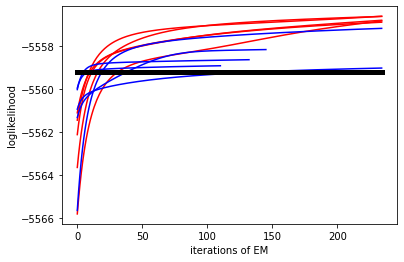

In [22]:
true_ll,_,_ = true_HMM.forwardPass(true_y,A_true,phi_true,pi0=None)

plt.plot(lls_EM.T[15:], color='red')
plt.plot(lls_DAEM.T[15:], color='blue')
plt.plot(np.ones(235)*true_ll,color='black',linewidth=5)
plt.xlabel('iterations of EM')
plt.ylabel('loglikelihood')

/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


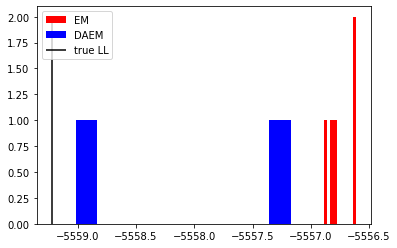

In [16]:
plt.hist(lls_EM[:,-1],color='red',label='EM')
plt.hist(lls_DAEM[:,-1],color='blue',label='DAEM')
plt.vlines(true_ll, 0, 2, color='black',label='true LL')
plt.legend()